In [ ]:
# EfficientNet-B7 achieves new state-of-the-art 84.4% top-1 / 97.1% top-5 accuracy year 2019 while being 8.4x
# smaller than the best existing CNN, e.g. EfficientNet-B1 is 7.6x smaller and 5.7x faster than ResNet-152.
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [1]:
from tensorflow.keras.applications import EfficientNetB5
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras import applications

import tensorflow as tf
import pandas as pd
import numpy as np
import os
print(os.listdir("./kaggle-dataset"))

train_dir = './kaggle-dataset/train'
train_df = pd.read_csv('./kaggle-dataset/train.csv')
print(train_df[:10])

train_df['has_cactus'] = train_df['has_cactus'].astype('str')

# Augmenting data using an ImageDataGenerator object in Keras
'''
rescale=1/255: Normalization by rescaling the pixel values of the images to be in the range [0, 1].
validation_split=0.10: Reserving 10% of the images for validation during training.
rotation_range=40: Augments the image by rotating a random angle between -40 and +40 degrees.
width_shift_range=0.2: Shifts the image horizontally by a random fraction of the total width, up to 20%.
height_shift_range=0.2: Shifts the image vertically by a random fraction of the total height, up to 20%.
shear_range=0.2: Applies a shear transformation by a random angle between -20 and +20 degrees.
zoom_range=0.2: Zooms the image by a random factor between 1.0-0.2=0.8 and 1.0+0.2=1.2.
horizontal_flip=True: Flips the image horizontally with a probability of 0.5.
fill_mode='nearest': Fills in any newly created pixels by copying the nearest valid pixel.
'''
train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.10,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)
# By the following code: if we have 1,000 images in input dataset,
# then there will be around 166,320 augmented images for training.

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col="id",
    y_col="has_cactus",
    target_size=(456,456),
    subset="training",
    batch_size=1, # 64 preferred (depending on the dataset size)
    shuffle=True,
    class_mode="binary" # The labels are binary (either 0 or 1).
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col="id",
    y_col="has_cactus",
    target_size=(456,456),
    subset="validation",
    batch_size=1, # 64 preferred (depending on the dataset size)
    shuffle=True,
    class_mode="binary" # The labels are binary (either 0 or 1).
)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

pretrained_net = EfficientNetB5(
    input_shape=(456,456,3), # Resolution fo EfficientNetB5
    include_top=False,
    weights="imagenet",
    pooling="avg",
)

model = Sequential()
model.add(pretrained_net)
model.add(Dense(units = 256, activation='relu'))
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    # validation_steps & steps_per_epoch need to be more than 0
    validation_steps = validation_generator.n//validation_generator.batch_size,
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    epochs = 10,
)

model.save('efficientnet_finetuned_epoch_100.h5')

2023-03-22 15:33:57.503723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 15:33:57.503754: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/gbike/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['train.csv', 'train']
                                     id  has_cactus
0  000c8a36845c0208e833c79c1bffedd1.jpg           1
1  000d1e9a533f62e55c289303b072733d.jpg           1
2  00a8c7e14298819281fe1a81434d19c4.jpg           1
3  00acf6bfe9ceefb3ea1e7629e4912a31.jpg           1
4  00b4dfbb267109b5f0d0dde365fa6161.jpg           1
5  00b5670821357d6de4c9eec458b9da86.jpg           0
6  00b5670821357d6de4c9eec458b9da87.jpg           0
7  00b5670821357d6de4c9eec458b9da88.jpg           0
8  00b5670821357d6de4c9eec458b9da89.jpg           0
9  00b5670821357d6de4c9eec458b9da90.jpg           0
Found 9 validated image filenames belonging to 2 classes.
Found 1 validated image filenames belonging to 2 classes.


2023-03-22 15:33:59.096623: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 15:33:59.096654: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 15:33:59.096674: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-255-120-161): /proc/driver/nvidia/version does not exist
2023-03-22 15:33:59.096863: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 31,662,328
Trainable params: 31,489,585
Non-trainable params: 172,743
_________________________________________________________________


/tmp/ipykernel_2060214/2137938369.py:87: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
9/9 [==============================] - 31s 2s/step - loss: 0.7658 - accuracy: 0.4444 - val_loss: 0.6595 - val_accuracy: 1.0000
Epoch 2/10
9/9 [==============================] - 11s 1s/step - loss: 0.6608 - accuracy: 0.5556 - val_loss: 0.6745 - val_accuracy: 1.0000
Epoch 3/10
9/9 [==============================] - 11s 1s/step - loss: 0.6372 - accuracy: 0.5556 - val_loss: 0.6849 - val_accuracy: 1.0000
Epoch 4/10
9/9 [==============================] - 11s 1s/step - loss: 0.5741 - accuracy: 0.5556 - val_loss: 0.7116 - val_accuracy: 0.0000e+00
Epoch 5/10
9/9 [==============================] - 11s 1s/step - loss: 0.4581 - accuracy: 0.7778 - val_loss: 0.6861 - val_accuracy: 1.0000
Epoch 6/10
9/9 [==============================] - 11s 1s/step - loss: 0.2903 - accuracy: 1.0000 - val_loss: 0.6113 - val_accuracy: 1.0000
Epoch 7/10
9/9 [==============================] - 11s 1s/step - loss: 0.1691 - accuracy: 1.0000 - val_loss: 0.4636 - val_accuracy: 1.0000
Epoch 8/10
9/9 [==============

/home/gbike/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


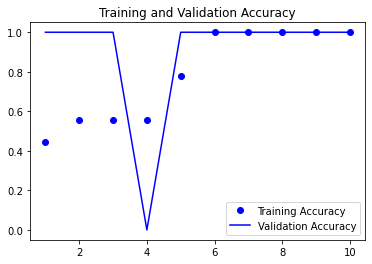

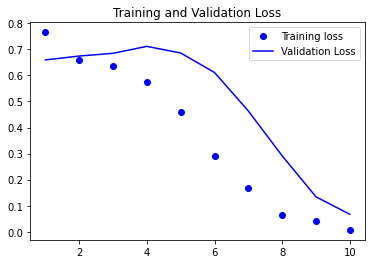

In [2]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [1]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np

model_loaded = load_model('efficientnet_finetuned_epoch_100.h5')

img_path = 'image.jpg'
img_resized = tf.keras.preprocessing.image.load_img(img_path, target_size=(456, 456)) # EfficientNetB5
img_vectorized = tf.keras.preprocessing.image.img_to_array(img_resized)
img_vectorized = tf.keras.applications.efficientnet.preprocess_input(img_vectorized)
img_vectorized = np.expand_dims(img_vectorized, axis=0)

output = model_loaded.predict(img_vectorized)
print(output)

2023-03-22 15:38:51.718066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 15:38:51.718099: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/gbike/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-03-22 15:38:53.260331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 15:38:53.260356: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03

[[0.9218565]]
